# Generate Features for Funny Words

In this notebook we take the data from the experiment (see stage 2 in the description of the project) and preprocess it. We also construct a series of features that can then be used for the analysis of the data.

Here is a short summary of the notebook:

1) Preliminary analysis and cleaning of the data
2) Defining the threshold for funnyness
3) Lemmatization of all words and coding of parts of speach
4) Coding of the length of words
5) Coding the ngrams that are found in the words
6) Coding of whether words include repeating syllables
7) Coding of lexical features of words (using wiki dictionary
8) Coding of phonetic features of words (using wiki dictionary)


# Install packeges

In [1]:
#install beautiful soup if it is not installed. we need it for web scraping
! pip install bs4

In [2]:
#install a library to lemmify words from Yandex
! pip install pymystem3

In [3]:
#install all the useful stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from bs4 import BeautifulSoup
import copy
import unicodedata
import sys
import requests
from pymystem3 import Mystem
import statsmodels.api as sm 

In [4]:
# Install different ML models from sklearn package
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Downloading and cleaning the data

In [154]:
# First we need to get the aggregated estimates by words
path = 'https://raw.githubusercontent.com/Chernechev/RussianFWords/main/RussianFWords_raw.csv'
df = pd.read_csv(path)

In [155]:
df.rename(columns={'Unnamed: 0':'word'}, inplace=True) # the first column isn't named  by default
df['word'] = [w.strip() for w in df['word']] # delete any spaces that could have crawled randomly in around the words

In [156]:
df.head() #look at the data

,word,orig_funny,group,item,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
0,yевмененько,funny,8.0,400,17.0,0.705882,0.469668,1.0,1.000000,NaN,16.0,0.687500,0.478714,16.0,0.750000,0.447214,1.0,0.0,NaN
1,абажур,funny,4.0,217,18.0,0.277778,0.460889,6.0,0.166667,0.408248,12.0,0.333333,0.492366,18.0,0.277778,0.460889,NaN,NaN,NaN
2,аборигенный,unfunny,33.0,1516,28.0,0.071429,0.262265,7.0,0.000000,0.000000,21.0,0.095238,0.300793,28.0,0.071429,0.262265,NaN,NaN,NaN
3,абсолютно,unfunny,44.0,1995,23.0,0.043478,0.208514,10.0,0.100000,0.316228,13.0,0.000000,0.000000,23.0,0.043478,0.208514,NaN,NaN,NaN
4,аварец,unfunny,33.0,1518,18.0,0.166667,0.383482,1.0,1.000000,NaN,17.0,0.117647,0.332106,18.0,0.166667,0.383482,NaN,NaN,NaN


In [157]:
# The column 'orig_funny' indicates whether the word was included in the first round of surveys.
# Here we numirize it. 1 means it was; 0 means it wasn't; 2 means that is the word used for calibration.
df.orig_funny = df['orig_funny'].map({'funny':1, 'unfunny':0, 'caliber':2})

In [158]:
# Here we delete the technical columns that were used for the experiment
df.drop(columns=['group','item'], inplace=True)

In [159]:
df.describe()

,orig_funny,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
count,2252.000000,2252.000000,2252.000000,2252.000000,2152.000000,2152.000000,1702.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,2252.000000,252.000000,252.000000,2.000000
mean,0.301510,16.994671,0.138989,0.200500,3.334572,0.134816,0.142682,13.808171,0.141831,0.196270,16.879218,0.138161,0.198055,1.031746,0.235714,0.447214
std,0.460947,21.836718,0.211821,0.199526,4.546322,0.270891,0.243699,17.723995,0.218764,0.204370,21.685519,0.212253,0.199947,0.355638,0.423788,0.000000
min,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.447214
25%,0.000000,14.000000,0.000000,0.000000,2.000000,0.000000,0.000000,11.000000,0.000000,0.000000,14.000000,0.000000,0.000000,1.000000,0.000000,0.447214
50%,0.000000,16.000000,0.055556,0.235702,3.000000,0.000000,0.000000,13.000000,0.058824,0.242536,16.000000,0.055556,0.226511,1.000000,0.000000,0.447214
75%,1.000000,18.000000,0.176471,0.377521,4.000000,0.166667,0.408248,15.000000,0.181818,0.389249,18.000000,0.168478,0.375534,1.000000,0.000000,0.447214
max,2.000000,736.000000,1.000000,0.534522,138.000000,1.000000,0.707107,598.000000,1.000000,0.534522,731.000000,1.000000,0.534522,5.000000,1.000000,0.447214


In [160]:
calibers = df[df['orig_funny'] == 2] # get only the two calibrating words
calibers

# here are the statistics for the calibrating words. 
# 'лампа' was given as an ultimate trivial unfunny word and got a funniness score of 0.02.
# 'пипидастр' was given as a rather funny word. 
# It was chosen because on the first stage it was proposed by people the most number of times. 
# It got the mean funniness score of 0.62.

,word,orig_funny,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
800,лампа,2,736.0,0.025815,0.158692,138.0,0.050725,0.220234,598.0,0.020067,0.140347,731.0,0.024624,0.155082,5.0,0.2,0.447214
1272,пипидастр,2,736.0,0.620924,0.485487,138.0,0.630435,0.484445,598.0,0.618729,0.486105,731.0,0.623803,0.484762,5.0,0.2,0.447214


So, we have estimations for 2252 unique words. We extract from there the 2 calibration words. The mean number of individuals giving estimations for every word is 16.99. The entire number of respondents is 736 (=count for caliber words)

In [161]:
# Delete the calibrating words
df.drop(calibers.index, inplace=True)

# Now we have to reset the index for the dataset
df.reset_index(inplace=True)
# and drop the old index
df.drop('index', axis=1, inplace=True) 

# do the same for the caliber dataframe to avoid confusion in the future
calibers.reset_index(inplace=True)

# Exploratory Data Analysis

In [162]:
# set colors for visualizations
fcolor = '#61c747'
ucolor = '#c74761'

In [163]:
only_f = df[df['orig_funny'] == 1.0] #dataset of only the originally funny words
only_u = df[df['orig_funny'] == 0.0] #dataset of only the random (originally unfunny) words

Text(0.5, 1.0, 'Number of responces per word')

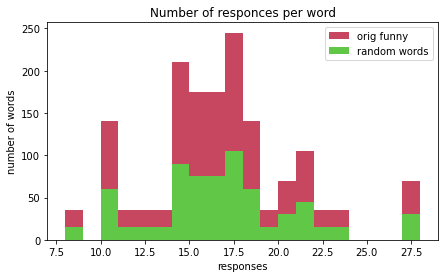

In [164]:
# plot the number of responces for the originally funny (red) and random (green) words
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(only_u['count'], bins=20, color=ucolor) # print the unfunny histogram
ax.hist(only_f['count'], bins=20, color=fcolor) # print funny histogram
ax.legend(['orig funny', 'random words'])
plt.xlabel('responses')
plt.ylabel('number of words')
ax.set_title('Number of responces per word')

It is not fully clear why the histogram looks this strange way. Why the number of reponses for one word is so strangely uneven?

It is due to something in the way the platform's randomness system was functioning. However, the distribution is the same for the funny and the unfunny words, and the distribution is normal-ish, so I wouldn't think about it too much. 

We see, however, that mode is around 17 responces and the lowest number of responces per word = 8. It is not bad!

Text(0.5, 1.0, 'The portion of originally funny words in the sample')

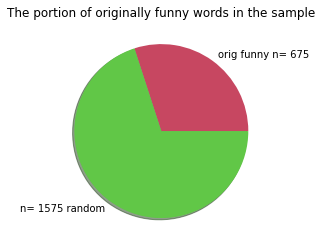

In [165]:
# A pie of the portion of funny words just for vsuals
for_pie = [only_f.shape[0], 
          only_u.shape[0]] #prepare the size of samples

plt.pie(for_pie, shadow=True, 
        labels=[f"orig funny n= {for_pie[0]}", f"n= {for_pie[1]} random"], colors=[ucolor,fcolor])
plt.gca().set_title('The portion of originally funny words in the sample')

## Demographics

## Number of reponces

In [166]:
calibers

,index,word,orig_funny,count,mean,std,male_count,male_mean,male_std,female_count,female_mean,female_std,youngly_count,youngly_mean,youngly_std,elderly_count,elderly_mean,elderly_std
0,800,лампа,2,736.0,0.025815,0.158692,138.0,0.050725,0.220234,598.0,0.020067,0.140347,731.0,0.024624,0.155082,5.0,0.2,0.447214
1,1272,пипидастр,2,736.0,0.620924,0.485487,138.0,0.630435,0.484445,598.0,0.618729,0.486105,731.0,0.623803,0.484762,5.0,0.2,0.447214


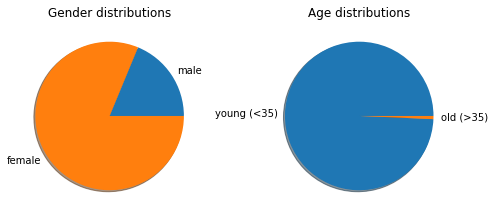

In [167]:
# get a list of the total number of men and women respondents
gend = [calibers.loc[0]['male_count'], calibers.loc[0]['female_count']] 
# get a list of the total number of young (under 35) and older (over 35) respondents
age = [calibers.loc[0]['youngly_count'], calibers.loc[0]['elderly_count']] 

# now plot the gender and age distributions
fig,ax = plt.subplots(figsize=(7,5), nrows=1, ncols=2)
ax[0].pie(gend, shadow=True, labels=['male', 'female'])
ax[0].set_title('Gender distributions')
ax[1].pie(age, shadow=True, labels=['young (<35)', 'old (>35)'])
ax[1].set_title('Age distributions')
plt.tight_layout()

In [168]:
print(f"There were {calibers.loc[0]['male_count']} male respondents and {calibers.loc[0]['female_count']} female repondents")

There were 138.0 male respondents and 598.0 female repondents


In [169]:
print(f"There were {calibers.loc[0]['youngly_count']} of respondents under 35 and {calibers.loc[0]['elderly_count']} respondents older than 35.")

There were 731.0 of respondents under 35 and 5.0 respondents older than 35.


The problems with the sample are obvious. It is talking mostly about women and mostly about young people. So the analysis inside the demographic sub-groups is pointless even for descriptive purposes.

In [170]:
# Drop the demographic columns
df.drop(columns=['male_count','male_mean', 'male_std', 
                 'female_count', 'female_mean', 'female_std',
                 'youngly_count', 'youngly_mean', 'youngly_std', 
                 'elderly_count','elderly_mean', 'elderly_std'], inplace=True)

## Mean ratings

(0.0, 100.0)

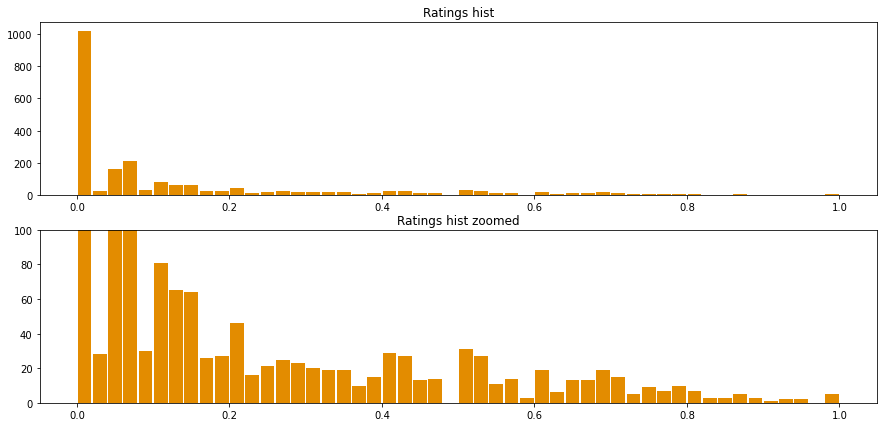

In [171]:
# plot the histogram of mean funniness

fig, ax = plt.subplots(nrows=2,figsize=(15,7))

ax[0].hist(df['mean'], bins=50, color='#e38c00', rwidth=0.9)
ax[0].set_title('Ratings hist')

#And then plot the same hist but zoomed to look past the huge pillar at 0
ax[1].hist(df['mean'], bins=50, color='#e38c00', rwidth=0.9)
ax[1].set_title('Ratings hist zoomed')
ax[1].set_ylim(0,100)

In [172]:
# Number of words with the mean rating of 0
df[df['mean'] == 0].shape

(1020, 5)

We see that almost a half of all words were marked by everyone as unfunny.

Now let us look at how these words relate to the originally funny.

Text(0.5, 1.0, 'Mean hist on log')

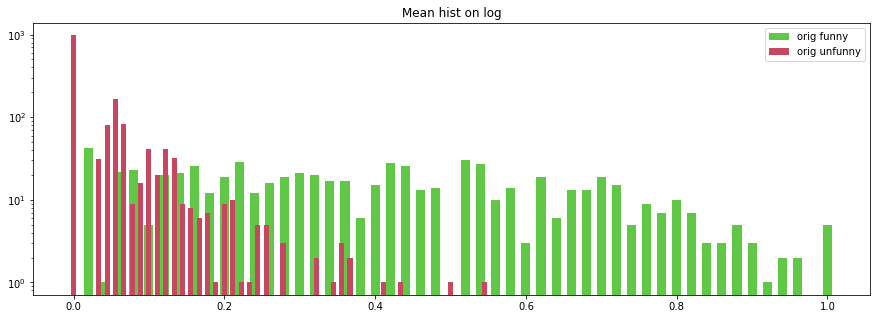

In [173]:
# plot the mean funniness rating of random and originally funny words using different colors.
# For the sake of visibility the histogram's y-axis is logarithmic

fig, ax = plt.subplots(figsize=(15,5))
ax.hist(only_f['mean'], bins=50, color=fcolor, log=True, align='right', rwidth=0.6) # plot the originally funny 
ax.hist(only_u['mean'], bins=50, color=ucolor, log=True, align='left', rwidth=0.6) # plot the random
ax.legend(['orig funny', 'orig unfunny'])
ax.set_title('Mean hist on log')

Text(0.5, 1.0, 'Mean hist')

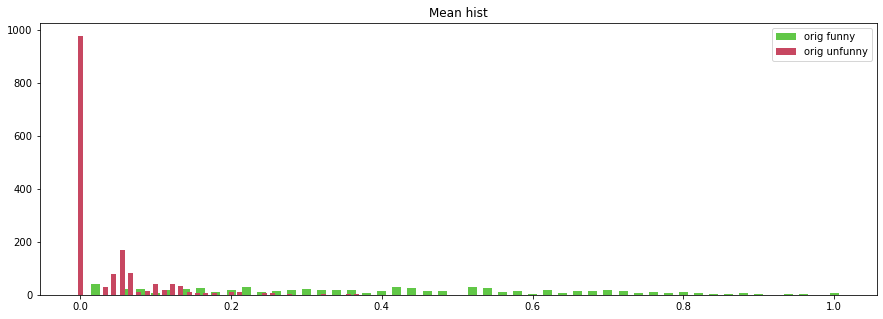

In [174]:
# The same hist but on a non-logarithmic scale

fig, ax = plt.subplots(figsize=(15,5))
ax.hist(only_f['mean'], bins=50, color=fcolor, align='right', rwidth=0.6)
ax.hist(only_u['mean'], bins=50, color=ucolor, align='left', rwidth=0.6)
ax.legend(['orig funny', 'orig unfunny'])
ax.set_title('Mean hist')

We see from this an interesting pattern: while the random words are distributed exponentially with a huge peak at 0, the originally funny words are more or less equally scattered across the distribution. 

### Marking the threshold

We decided to set the threshold for funnyness at 0.5. It makes sense logically.

It leaves us with 202 words assigned funny and 2048 words assigned unfunny. Or 8.98 percent funny VS 91.02 percent unfunnny.

In [175]:
# Create the column 'funny' on the condition of mean being more or equal to 0.5.
df['funny'] = [1 if x >= 0.5 else 0 for x in df['mean']]

In [176]:
# Make two dataframes with only the words assigned funny and unfunny as a result 
funny = df[df['funny'] == 1]
dull = df[df['funny'] == 0]

### Standard deviation  
In this case the measures of spread can be interpreted as how contested is the matter of its funnyness. 
The higher the std, the more debated is its funnyness

Text(0.5, 1.0, 'STD for words by assigned funnyness (hist on log)')

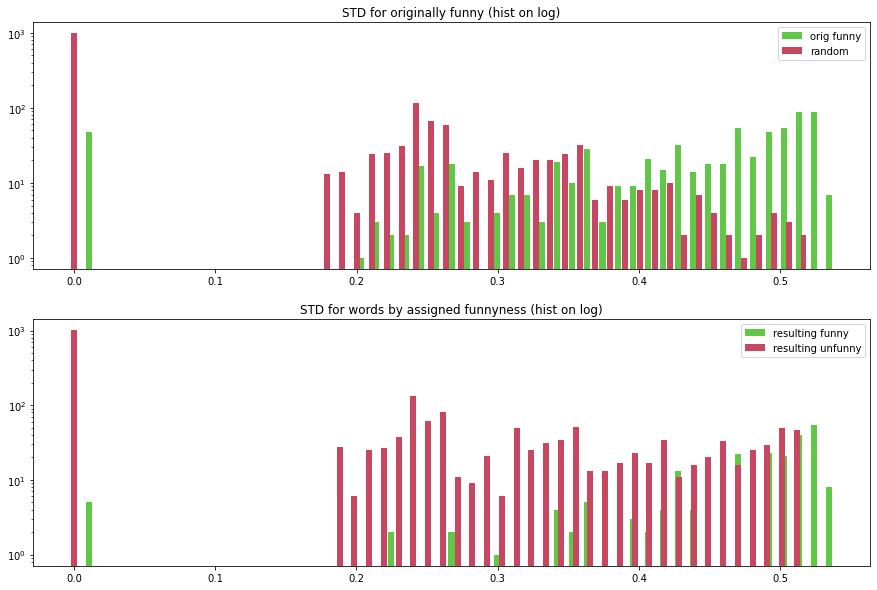

In [177]:
# plot the std (on log for convinience)
# The first plot is about the results
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].hist(only_f['std'], bins=50, color=fcolor, log=True, align='right', rwidth=0.4)
ax[0].hist(only_u['std'], bins=50, color=ucolor, log=True, align='left', rwidth=0.4)
ax[0].legend(['orig funny', 'random'])
ax[0].set_title('STD for originally funny (hist on log)')

ax[1].hist(funny['std'], bins=50, color=fcolor, log=True, align='right', rwidth=0.4)
ax[1].hist(dull['std'], bins=50, color=ucolor, log=True, align='left', rwidth=0.4)
ax[1].legend(['resulting funny', 'resulting unfunny'])
ax[1].set_title('STD for words by assigned funnyness (hist on log)')

It is interesting that  the words with the highest std is the originally funny words.

# * HERE COME THE FUNNY WORDS!

In [178]:
# Here is a long list of funny words by their mean comedic estimation.
# For the pleasure and giggles of Russian-speaking peoples.
pd.set_option('display.max_rows', funny.shape[0]) 
funny.sort_values('mean', ascending=False)

,word,orig_funny,count,mean,std,funny
118,бубылда,1,14.0,1.000000,0.000000,1
2082,фунфырик,1,13.0,1.000000,0.000000,1
2236,эчпочмак,1,14.0,1.000000,0.000000,1
618,кандибобер,1,17.0,1.000000,0.000000,1
450,жабик,1,13.0,1.000000,0.000000,1
2159,чилипиздрик,1,21.0,0.952381,0.218218,1
423,дудонить,1,21.0,0.952381,0.218218,1
738,кошонята,1,14.0,0.928571,0.267261,1
1556,пуцка,1,14.0,0.928571,0.267261,1
1235,пек-пек-пек,1,12.0,0.916667,0.288675,1


**Several notes**

Just from reading this list several things can be noted. A lot of these words are diminutives (e.g. "ясельки"). Or they have parts of the word that sound like diminutive suffixes ("зяблик") A couple of them are obsene ("хуек" – a diminutive for a dick, "пися" – a strange, somewhat childish word for genitalia regardless of gender). Yet a couple are related to animals ("хорь" – a ferret, "мышь" – a mouse).

# Feature engineering

Now let us get to generating features that can be used for analysis and prediction.

Technically, I would have to split the test and train samples at this point to correctly extract the features.
It was like this before, but now for the sake of analysis I split the train and the test just before training each model.

## Lemmatization

First we have to bring all words to the basic form. And also mark what part of speach is it.
We use ["MyStem"](https://yandex.ru/dev/mystem/) the lemmatization engine developed by Yandex.

It's easy and efficient. Its greatest strength is that it can lemmatize even words that are not found in dictionaries. This is important because our originally funny words are sometimes quite niche.

In [179]:
m = Mystem() # creating the object
wrong_words = [] # an empty list for the future

# Now I need to create a translator for parts of speach marks as MyStem marks them with its own pattern

# I get the dictionary from gitHub
mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'
r = requests.get(mapping_url, stream=True)

# using the data from gitHub I create a dictionary "mystem2upos"
mystem2upos = {}
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

In [180]:
# using the default functions of mystem I create a tagger function
def tag_mystem(text, bastards=True, mapping=mystem2upos):
    
    '''
This function takes in raw text in russian (one sentence per line).
It is tockenized, lemmatized and marked according to the part of speach, using Mystem.
The function returns a series of words with words with parts of speach.
Example: "зеленый_NOUN трамвай_NOUN".
'''
    # Processing the words 
    text = text.strip() 
    processed = m.analyze(text)
    w = processed[0]
     
    #lemmatize and everything
    try:
        lemma = w["analysis"][0]["lex"].lower().strip()
        pos = w["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
    except IndexError:
        print(w)
    
    if pos in mapping:
        pos = mapping[pos]  # Here we change the part of speach tags with our dictionary
    else:
        pos = 'X'  # In case we get a tag that can't be found in the dictionary
    
    tagged = lemma.lower() + '_' + pos # create final tagged word
    
    # If the word can't be found in the dictionary, it is marked as a 'bastard'. I ask to mark these words.
    bast = 0
    if bastards is True:
        try:
            if w['analysis'][0]['qual'] == 'bastard':
                bast = 1
        except KeyError:
            pass
    
    # this function returns a lemmatized word; 
    #a lemmatized word with the part of speach marked; 
    #and a 1/0 describing whether this word can be found in a dictionary
    return lemma.lower(), tagged, bast

In [181]:
# We went through all the tagged words and corrected all the errors MyStem made. 
# And all the writing errors that were present in the originally funny words.
wrong_marked = {'шаболд_NOUN':'шаболда_NOUN', 
                'порабабан_NOUN':'порабабану_ADV', 
                'нунчак_NOUN':'нунчаки_NOUN',
                'пуцк_NOUN':'пуцка_NOUN',
                'епстудэй_NOUN':'епстудэй_INTJ',
                'гнидок_NOUN':'гнидка_NOUN',
                'ебак_NOUN':'ебака_NOUN',
                'продриснять_VERB':'продриснуть_VERB',
                'кабас_NOUN':'кабаса_NOUN',
                'кутешат_NOUN':'кутешонок_NOUN',
                'ебенить_VERB':'ебеня_NOUN',
                'охйовзес_NOUN':'охйовзес_INTJ',
                'астралябия_NOUN':'астролябия_NOUN',
                'плюмбум_ADV':'плюмбум_NOUN',
                'гупешок_NOUN':'гупешка_NOUN',
                'мыш_NOUN':'мышь_NOUN',
                'треугольничка_NOUN':'треугольничек_NOUN',
                'яселек_NOUN':'ясельки_NOUN',
                'блеб_NOUN':'блеба_NOUN',
                'чупакабр_NOUN':'чупакабра_NOUN',
                'бровье_NOUN':'бровь_NOUN',
                'мюзле_ADV':'мюзле_NOUN',
                'дудык_NOUN':'дудыка_NOUN',
                'зимбур_NOUN':'зимбура_NOUN',
                'посюстороной_ADJ':'посюсторонний_ADJ',
                'сукалень_NOUN':'сукалень_INTJ',
                'уевмененький_ADJ':'уевмененько_ADV',
                'ювелирок_NOUN':'ювелирка_NOUN',
                'ржомб_NOUN':'ржомба_NOUN',
                'шлюшандр_NOUN':'шлюшандра_NOUN',
                'мамонный_ADJ':'мамона_PROPN',
                'апоп_NOUN':'апоп_PROPN',
                'зазауль_NOUN':'зазауля_NOUN',
                'сподвыподверт_NOUN':'сподвыподвертом_ADV',
                'изподподвыподверт_NOUN':'изподподвыподверта_ADV',
                'обезьяньяног_NOUN':'обезьяньянога_NOUN',
                'фаберже_NOUN':'фаберже_PROPN',
                'престидиджижитатор_NOUN':'престидижитатор_NOUN',
                'чевапчича_NOUN':'чевапчичи_NOUN',
                'колыван_NOUN':'колыван_PROPN',
                'скокм_NOUN':'скокма_PRON',
                'барбариск_NOUN':'барбариска_NOUN',
                'дапкунать_VERB':'дапкунайте_PROPN',
                'попандопадать_VERB':'попандопуло_PROPN',
                'володя_NOUN':'володя_PROPN',
                'черномырдин_NOUN':'черномырдин_PROPN',
                'краков_NOUN':'краков_PROPN',
                'чулышман_NOUN':'чулышман_PROPN',
                'исключительно_PART':'исключительно_ADV',
                'когда_ADV':'когда_SCONJ',
                'ингеборга_NOUN':'ингеборга_PROPN',
                'ауфа_NOUN':'ауф_INTJ',
                'иной_DET':'иной_PRON',
                'один_DET':'один_NUM',
                'крым_NOUN':'крым_PROPN',
                'гваделупа_NOUN':'гваделупа_PROPN',
                'никак_PART':'никак_PRON',
                'ядвига_NOUN':'ядвига_PROPN',
                'после_ADV':'после_ADP',
                'александр_NOUN':'александр_PROPN',
                'федор_NOUN':'федор_PROPN',
                'сызрань_NOUN':'сызрань_PROPN',
                'илья_NOUN':'илья_PROPN',
                'вилли_NOUN':'вилли_PROPN',
                'камю_NOUN':'камю_PROPN',
                'бугульма_NOUN':'бугульма_PROPN',
                'однако_SCONJ':'однако_INTJ',
                'куда_ADV':'куда_PRON',
                'почти_ADV':'почти_ADP',
                'ванючка_NOUN':'вонючка_NOUN'
                }

In [182]:
df.head()

,word,orig_funny,count,mean,std,funny
0,yевмененько,1,17.0,0.705882,0.469668,1
1,абажур,1,18.0,0.277778,0.460889,0
2,аборигенный,0,28.0,0.071429,0.262265,0
3,абсолютно,0,23.0,0.043478,0.208514,0
4,аварец,0,18.0,0.166667,0.383482,0


In [183]:
# lemmatize the words in the dataset
for w in df['word']:
    lemmed, stemed, bast = tag_mystem(w) # process the word
    
    #check that the word is not one of those wrong marked and correct
    if stemed in wrong_marked:
        stemed = wrong_marked.get(stemed)
    
    #now we have to write the new info back into the df
    index = df[df['word'] == w].index[0] #get the index of the word in the df
    
    #and write into the respective columns
    df.loc[index,'stem'] = stemed 
    df.loc[index,'lem'] = lemmed
    df.loc[index,'stem_bastard'] = bast

In [184]:
print(f"Tagged {len(df['stem'])} words out of {df.shape[0]} \nThere are {df[df['stem_bastard'] == 1].shape[0]} bastards")

Tagged 2250 words out of 2250 
There are 202 bastards


## Formal features


### Length of words

First of all we want to code the length of words in charecters

In [185]:
# mark the length of the word
df['length'] = [len(w.strip()) for w in df['word']]

Text(0.5, 0, 'length of word')

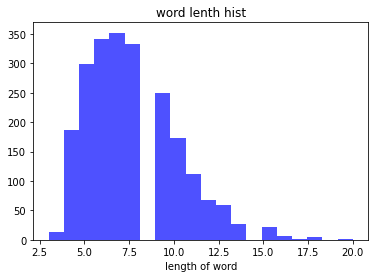

In [186]:
# plot the distribution of word lengths
plt.hist(df.length, bins=20, color='#4e51ff')
plt.gca().set_title('word lenth hist')
plt.xlabel('length of word')

Text(0.5, 1.0, 'Length of words by assigned funnyness')

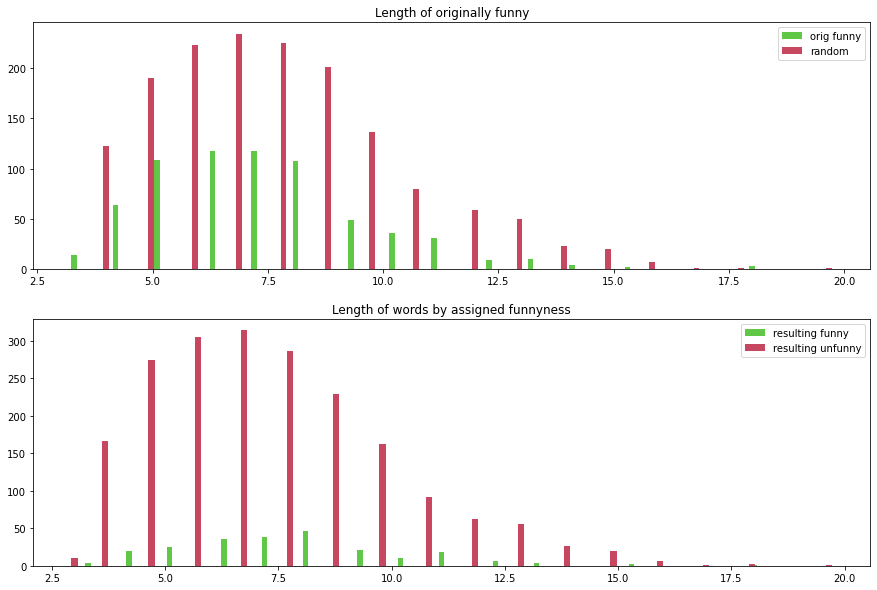

In [187]:
# plot the length of funny and unfunny (modify the script from above)

fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].hist(df[df['orig_funny'] == 1]['length'], 
           bins=50, color=fcolor, align='right', rwidth=0.4)

ax[0].hist(df[df['orig_funny'] == 0]['length'], 
           bins=50, color=ucolor, align='left', rwidth=0.4)
ax[0].legend(['orig funny', 'random'])
ax[0].set_title('Length of originally funny')

ax[1].hist(df[df['funny'] == 1]['length'], 
           bins=50, color=fcolor, align='right', rwidth=0.4)
ax[1].hist(df[df['funny'] == 0]['length'], 
           bins=50, color=ucolor, align='left', rwidth=0.4)
ax[1].legend(['resulting funny', 'resulting unfunny'])
ax[1].set_title('Length of words by assigned funnyness')

The distribution of word lengths seems pretty similar

In [188]:
print(f"Mean length:\nfunny = {df[df.funny == 1].length.describe()[1]}\nunfunny = {df[df.funny == 0].length.describe()[1]}\ntotal = {df.length.describe()[1]}")

Mean length:
funny = 7.497854077253219
unfunny = 7.653941497273178
total = 7.637777777777778


### N-grams

Now we generate N-grams, that is code the combinations of n character for n <= 3. 

Also, we set a threshold: we don't include an n-gram if it is featured in less than 5 words. This is done to avoid an over-fit.

#### Extracting 

In [206]:
# Generate n-grams with n=3

cv = CountVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=5) # create the vectorizer object and set the threshold
cv.fit(df['word']) # fit to the data
ngram_names = cv.get_feature_names_out() # get the list of all ngrams

# And now we get the matrix of ngrams
ngram_matrix = cv.transform(df['word'])
# And turn it into a dataframe
ngram_df = pd.DataFrame.sparse.from_spmatrix(ngram_matrix, columns=ngram_names, index=df.index) 

# However, some of the ngrams have spaces around the letters. We want to get rid of them
# We get the list of only the ngrams we need
strip_ngram_names = [x.strip() for x in ngram_names] # strip all names
strip_ngram_names = list(set(ngram_names)) #delete the reoccuring

# Now we delete the unneeded ngram columns
ngram_df = ngram_df[strip_ngram_names]

In [211]:
# And now we add all ngrams to the df
# but first we change the names of columns to mark them as ngrams
ngram_df.columns = ['ngram_' + x for x in ngram_df.columns]

# And now add the ngrams to the big df
df = df.concat([df, ngram_df])

#### Logistic model unigram


In [43]:
def find_by_ngram(string):
    """
    A small function that takes in an n-gram string and returns a list of funny words that have it 
    and an unfunny words that have it
    """
    funny_result, unfunny_result = [],[] # create two empty lists
    for item in df[df['funny'] == 1]['word']: # if string in word add it to the list
        if string in item:
            funny_result.append(item)
            
    for item in df[df['funny'] == 0]['word']:
        if string in item:
            unfunny_result.append(item)
    return funny_result, unfunny_result

Let's first look at how the Logistic regression works for unigrams (individual letters)

In [44]:
def top_features(importance_array, n_features, names, title='feature importance', plot=True):
    '''
    This function takes the results of a random forest model and turns it into a plot of features with importance
    '''
    d = pd.DataFrame(data = importance_array, index = names, columns=['Importance'])
    d = d.sort_values(by = 'Importance', ascending = False)
    if plot is True:
        return d[0:n_features].plot(kind='bar', title=title)
    else:
        return d[0:n_features]

In [45]:
# defining the samples for the moment
X = uni_df
y = df['funny']

# and making a train-test split to assess how well the model is at predicting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'test score')

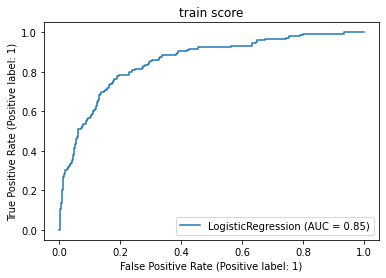

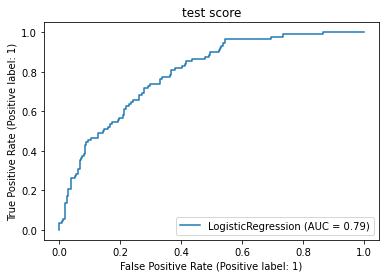

In [46]:
#let's look at how a linear model trains and performs 

# first we set a linear model in sklearn
log = LogisticRegression().fit(X_train, y_train)

plot_roc_curve(log, X_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(log, X_test, y_test)
plt.gca().set_title('test score')

The result is not very good, but it is consistent for the train and the test.

But let us look in detail at the coefficients (here we use the entire dataset, not only the train)

In [47]:
# And here I use the sm library because sklearn is tough to analyze

X = sm.add_constant(X) # Add an intercept
results = sm.OLS(y,X).fit() # Run the model
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  funny   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     12.62
Date:                Sun, 14 Jan 2024   Prob (F-statistic):           1.80e-61
Time:                        02:50:00   Log-Likelihood:                -324.73
No. Observations:                2250   AIC:                             717.5
Df Residuals:                    2216   BIC:                             911.9
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
               0.0004      0.010      0.039      0.969      -0.019       0.020
а              0.0081      0.010      0.812      0.417      -0.011       0.027
б              0.0957      0.017      5.731      0.000       0.063       0.129
в              0.0042      0.014      0.304      0.761      -0.023       0.032
г              0.0141      0.022      0.643      0.521      -0.029       0.057
д              0.0422      0.015      2.856      0.004       0.013       0.071
е             -0.0073      0.011     -0.688      0.491      -0.028       0.013
ж              0.0494      0.024      2.082      0.037       0.003       0.096
з              0.0135      0.018      0.743      0.458      -0.022       0.049
и             -0.0184      0.010     -1.792      0.073      -0.038       0.002
й             -0.0835      0.018     -4.545      0.000      -0.120      -0.047
к              0.0916      0.012      7.842      0.000       0.069       0.114
л              0.0273      0.014      2.012      0.044       0.001       0.054
м              0.0335      0.016      2.108      0.035       0.002       0.065
н              0.0011      0.011      0.106      0.915      -0.020       0.022
о             -0.0267      0.010     -2.690      0.007      -0.046      -0.007
п              0.0894      0.013      6.886      0.000       0.064       0.115
р             -0.0310      0.011     -2.769      0.006      -0.053      -0.009
с          -9.513e-05      0.011     -0.009      0.993      -0.021       0.021
т             -0.0267      0.011     -2.429      0.015      -0.048      -0.005
у              0.0910      0.015      5.959      0.000       0.061       0.121
ф              0.1160      0.031      3.690      0.000       0.054       0.178
х              0.1561      0.029      5.383      0.000       0.099       0.213
ц              0.0065      0.028      0.231      0.817      -0.049       0.061
ч              0.0677      0.019      3.564      0.000       0.030       0.105
ш              0.1186      0.021      5.545      0.000       0.077       0.160
щ             -0.0269      0.046     -0.588      0.556      -0.117       0.063
ъ             -0.0943      0.108     -0.875      0.382      -0.306       0.117
ы              0.0410      0.020      2.019      0.044       0.001       0.081
ь              0.0061      0.015      0.407      0.684      -0.023       0.036
э             -0.0294      0.056     -0.530      0.596      -0.138       0.079
ю              0.0801      0.034      2.383      0.017       0.014       0.146
я              0.0785      0.019      4.218      0.000       0.042       0.115
ё              0.0409      0.040      1.018      0.309      -0.038       0.120
==============================================================================
Omnibus:                      872.812   Durbin-Watson:                   1.846
Pr

In [48]:
# visualization code borrowed from 
# https://medium.com/@ginoasuncion/visualizing-logistic-regression-results-using-a-forest-plot-in-python-bc7ba65b55bb
# It is explained in detail there

def plot_coefs(model):
    '''
    visualization code borrowed from 
    https://medium.com/@ginoasuncion/visualizing-logistic-regression-results-using-a-forest-plot-in-python-bc7ba65b55bb
    It is explained in detail there
    '''
    params = model.params
    conf = model.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
    # convert log odds to ORs
    odds = pd.DataFrame(np.exp(conf))
    # check if pvalues are significant
    odds['pvalues'] = model.pvalues
    odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
    odds


    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
    for idx, row in odds.iloc[::-1].iterrows():
        ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
        if row['significant?'] == 'significant':
            plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
                ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                         markersize=5, mfc="tab:red", mec="tab:red")
        else:
            plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
                ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                         markersize=5, mfc="tab:gray", mec="tab:gray")
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
    plt.tight_layout()
    # plt.savefig('forest_plot.png')
    plt.show()

    # Red nodes are the statistically significant ones

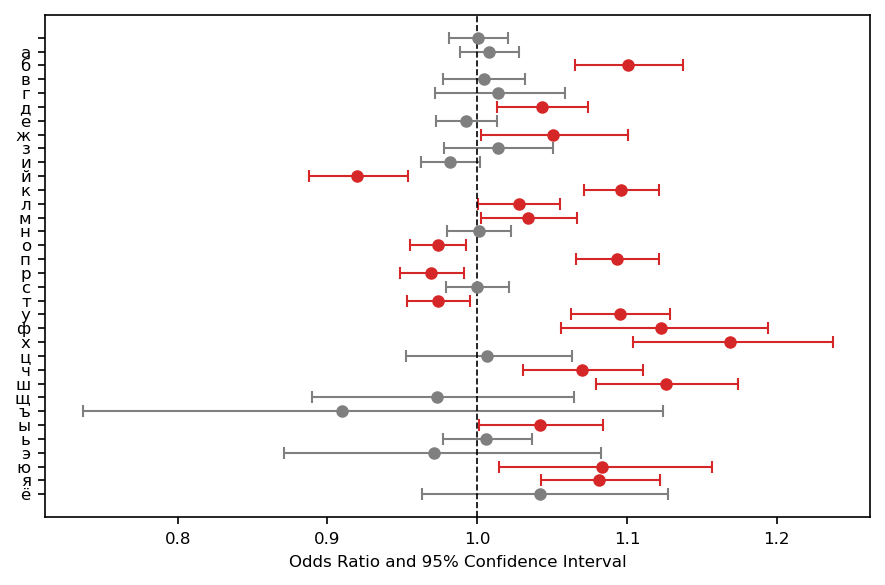

In [49]:
plot_coefs(results)

**Commentary**

The plot is a bit messy, but some things can be deciphered. For one, "ф", "х", "ц", "ч", "щ" – sibilant consonants – have a significant positive coefficient. Also, me may notice that k is significant. This is interesting, first, because it is featured in a series of diminiutive suffixes, and, second, because it accords with the english study which showed that "k" is the funniest consonant.

#### Logistic model ngram
Now we do the same thing for the big ngram dataframe

In [50]:
# defining the samples for the moment
X = ngram_df
y = df['funny']

# and making a train-test split to assess how well the model is at predicting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [51]:
# train the model
log = LogisticRegression().fit(X_train,y_train)

/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'test score')

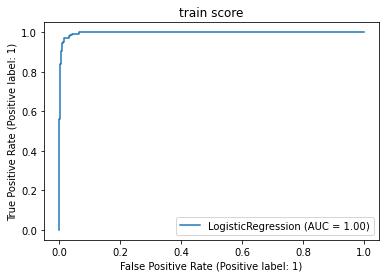

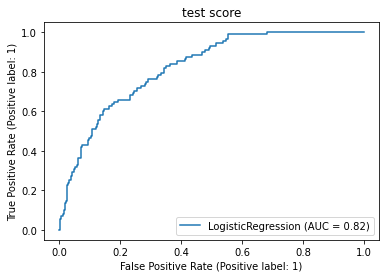

In [52]:
plot_roc_curve(log, X_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(log, X_test, y_test)
plt.gca().set_title('test score')

Judging by the ROC AUC, this model has much better predicting qualities. This makes sense because there SO MANY features.

And now we may look at the most important features. As there are A LOT of features I look only on those that are statistically significant and the most important (positive and negative)

In [53]:
# make the OLS model
X = sm.add_constant(X) # Add an intercept
results = sm.OLS(y,X).fit() # Run the model

In [54]:
# prepare the results
coefDF = pd.concat([results.params, results.pvalues],axis=1) # create a df from coefs
coefDF.columns = ['coefs','pvalues'] # name columns
coefDF.sort_values('coefs', inplace=True) #sort by coefs

# how many are statistically significant?
print(f"There are {coefDF.shape[0]} variabls. Only {coefDF[coefDF.pvalues < 0.05].shape[0]} of them are statistically significant with p-value < 0.05")

There are 1349 variabls. Only 104 of them are statistically significant with p-value < 0.05


In [55]:
# try to tweach the previous function to show only the most important features
def plot_top_coefs(model, n_top=5):
    '''
    see the original function "plot_top_coefs"
    '''
    params = model.params
    conf = model.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
    # convert log odds to ORs
    odds = pd.DataFrame(np.exp(conf))
    # check if pvalues are significant
    odds['pvalues'] = model.pvalues
    odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]

    #hear is my addition
    odds.sort_values('Odds Ratio', inplace=True) #sort by coefs
    odds = odds[odds['significant?'] == 'significant'] # take only the significant
    odds = pd.concat([odds.tail(n_top), odds.head(n_top)], axis=0) # take only the top 5 and the low 5
    


    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
    for idx, row in odds.iloc[::-1].iterrows():
        ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
        if row['significant?'] == 'significant':
            plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
                ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                         markersize=5, mfc="tab:red", mec="tab:red")
        else:
            plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
                ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                         markersize=5, mfc="tab:gray", mec="tab:gray")
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
    plt.tight_layout()
    # plt.savefig('forest_plot.png')
    plt.show()

    # Red nodes are the statistically significant ones

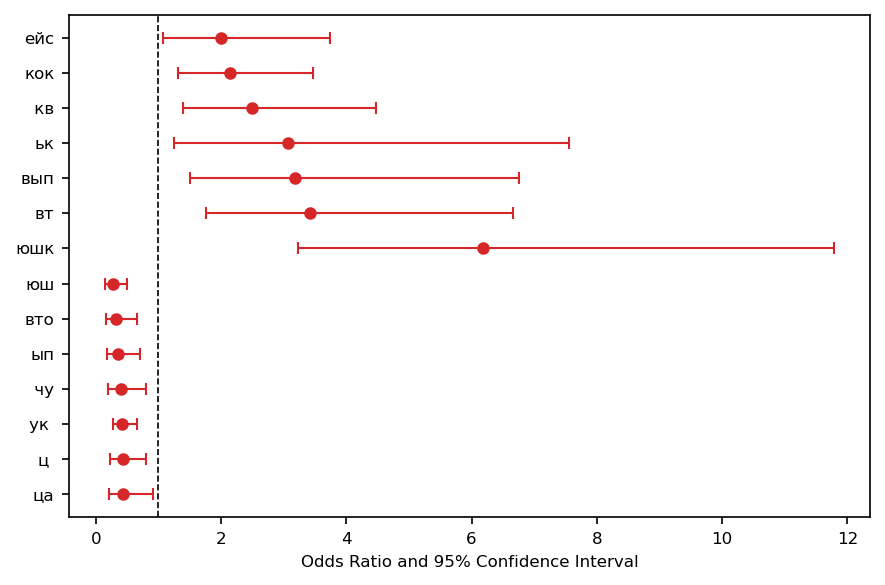

In [56]:
plot_top_coefs(results, n_top=7)

**Comment:**
    
Interestingly "ц" moved into a negative coefficent sphere. Some n-grams are recognisable as suffixes, for example "юшк". Also some of the n-grams include the letter "к" that we've mentioned above.

#### A random forest?..

We also tried to use a random forest for predicting this. Even though a forest is not very interpretable.

In [57]:
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/pashache/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'test score')

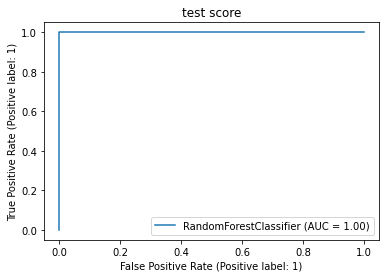

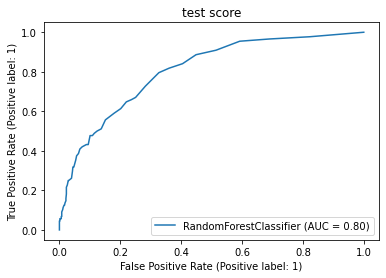

In [58]:
plot_roc_curve(forest, X_train, y_train)
plt.gca().set_title('test score')
plot_roc_curve(forest, X_test, y_test)
plt.gca().set_title('test score')

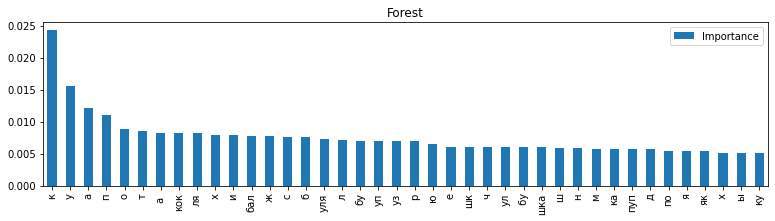

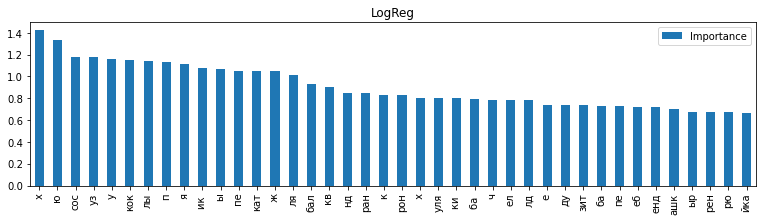

In [59]:
top_features(forest.feature_importances_, 40, ngram_names, title='Forest')
plt.gcf().set_size_inches((13,3))
top_features(log.coef_.T, 40, ngram_names, title='LogReg')
plt.gcf().set_size_inches((13,3))

#### Adding N-grams as a feature

I want to add the features that have proved the most influential in the OLS.

In [60]:
# take the top and last 10 features
top_features = pd.concat([coefDF.head(10), coefDF.tail(10)], axis=0)
top_features = top_features.index # take only the n grams

In [61]:
# for each top ngram take the occurence matrix from the ngrams and write it into the main df
for ngram in top_features:
    df[ngram] = ngram_df[ngram] 

### Repeated (is there a ngram that is repeated)

Some of the words can be funny because some parts of them are repeated. For example 'nomnom'. 

Here we turn this into a feature using the CountVectorizer object

In [ ]:
# First create a df of all ngrams with n > 2

# make a df of all ngrams with 2 <= n <= 3
cv = CountVectorizer(ngram_range=(2, 3), analyzer='char_wb') # create the vectorizer object
cv.fit(df['word']) # fit to the data
ngram_names = cv.get_feature_names_out() # get the list of all ngrams

all_ngrams = pd.DataFrame.sparse.from_spmatrix(cv.transform(df['word']), # get the ngram matrix and transform it into a dataframe
                                                 columns=ngram_names, index=df.index) 

# Now i have to get rid of all ngrams that consist of one letter and a space. 
# not clear why they are showing up: I stripped the data 

needed_ngrams = [x.strip() for x in all_ngrams.columns 
                 if len(x.strip()) > 1] # get a list of ngrams > 1. 

# Now drop the columns that are just letters
all_ngrams = all_ngrams[needed_ngrams]

In [ ]:
# Now all we need to do is find the two's in this matrix – and that will be the words that have repetitions
# This takes some time, so be prepared

repeated = [] # an empty list to turn into a column later

for word_i in df.index:
    
    if 2 in all_ngrams.iloc[[word_i]].values: # is there a 2 in the row with index word_i?
        repeated.append(1)
    else:
        repeated.append(0)
        
df['repeated'] = repeated

## Wiki Dictionary

We wiki dictionary to get two types of things. First, the phonetics. It is interesting how they relate to the letters.
Second, we want to get the lexical markers for words such as 'obsene', 'jargon', .elevated' etc. 
For this we have to scrape the web. Wiki Dictionary is acessable and big, including even the most recent words, unlike many academic dictionaries.

### Parsing Wiki

In [212]:
# First of all I want to get the list of all existing lexical tags

# get the webpage with the list of tags
tagpage = requests.get('https://ru.wiktionary.org/wiki/Викисловарь:Условные_сокращения')
soup0 = BeautifulSoup(tagpage.content, 'html.parser') # turn it into a html

# get all the tag names elements (found using SelectorGadget) and extract their text
wiki_tags = [x.string for x in soup0.findAll('i')]

In [63]:
# Make a function that looks up a word on wiki, extracts the phonetics and the tags
# Make it a single function not to lookup the website two times
def lookup_wiki(word):
    '''
    The function takes in a word in its lemmatized form 
    and yields the phonetic verstion of the word and a list of all lexical tags. 
    '''
    
    # Download the page for each word
    link = 'https://ru.wiktionary.org/wiki/' + word
    page = requests.get(link) # get the page
    soup = BeautifulSoup(page.content, 'html.parser') # turn into a parsable html
    
    # Get transcription.
    # Do through try in case a transcription is not available
    try:
        ip = soup.find('span', {'class': 'IPA'}).string
        ip = str(ip.string) # get the text from html
    except: 
        ip = 'nan' # if transcription is not available
        

    # Get the tags for each word
    # Make a TRY in case it doesn't exist in the dictionary
    try:
        ol = soup.find_all('ol')[0] # find the block with all word meanings
        tagstags = ol.find_all('a', {'title':'Викисловарь:Условные сокращения'}) # get all the tags
        
        final_tags = []
        # for all existing tag blocks
        for tagtag in tagstags:
            tt = tagtag.findChildren('span')[0].string # get the necessary block
            final_tags.append(tt)
        # Write it into the table    

    except:
        final_tags = 'not in wiki'
    
    final_tags = list(set(final_tags)) # a trick to delete all the re-occuring tags
    return ip, final_tags

Now, using this function we need to create new columns in the dataframe. 
For the phonetics, we'll just add it in a new column. 

For the lexical tags we will use the full list of tags
to create dummy variables and than fill them in

### Code the tags

In [64]:
# Create empty columns for tags
# And we mark them as tags
tag_name = 'tag_' + tag
for tag in wiki_tags:
    tag_name = 'tag_' + tag
    df[tag_name] = 0

/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/1679506758.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = 0
/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/1679506758.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = 0
/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/1679506758.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [65]:
# a loop for looking up all the words
# It takes A LOT of time naturally
for i in df.index:
    word = df.loc[i,'word']
    ip, tags_list = lookup_wiki(word)

    # put the phonetic in the df
    df.loc[i, 'ipa'] = ip
    
    # put in the tags
    for tag in tags_list:
        df.loc[i,tag] = 1

/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/351240335.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[i, 'ipa'] = ip
/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/351240335.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[i,tag] = 1
/var/folders/s6/2cb6sfpn54q48xnzlvd12qz00000gn/T/ipykernel_87442/351240335.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

### Processing phonetics

Now to make transcriptions into features we need to turn phonetics into a list of dummy variables.
First we look at how many transcriptions are available

In [78]:
print(f"Transcriptions are found for {len(df.ipa[df.ipa != 'nan'])} words.\nNo transcriptions for {len(df.ipa[df.ipa == 'nan'])} words.")

Transcriptions are found for 2062 words.
No transcriptions for 188 words.


In [92]:
# and more detailed view
print(f"""Funny without transcription: {df[(df.funny == 1) & (df.ipa == 'nan')].shape[0]}.
Unfunny without transcription: {df[(df.funny == 0) & (df.ipa == 'nan')].shape[0]}""")

Funny without transcription: 103.
Unfunny without transcription: 85


Phonetic signes are not as easy to parse as letters. Because some sounds consist of several symbols. 
So we need a catalogue of existing sounds.

In [147]:
# Get the webpage with all sound signs
soundPage = requests.get('https://ru.wikipedia.org/wiki/Таблица_МФА_для_русского_языка')
# Create the soup object
soundSoup = BeautifulSoup(soundPage.content, 'html.parser')

# Get all blocks with sounds
css_path = '.wikitable:nth-child(1) .IPA a'  # from selector gadget. get only phonetic symbols
sound_tags = soundSoup.select(css_path)

# Get sounds as strings
soundList = [tag.string for tag in sound_tags]

# Turn all the sounds into an empty df to code the presence of sounds in the df.
soundDf = pd.DataFrame(index=range(len(df.index)),columns=soundList) 
soundDf.fillna(0, inplace=True) # Turn the basic NaNs into 0s
soundDf['noTranscription'] = 0 # Add a dummy of 0s for words that don't have transcription

In [148]:
# Now code a in the phonetics appearence into the soundDf
for i in df.index:
    transcription = df.loc[i, 'ipa']
    # In case there is no transcription
    if transcription == 'nan': 
        soundDf.loc[i, 'noTranscription'] = 1
    
    else:
        # Check the presence for every sound and record it
        for sound in soundList:
            if sound in transcription:
                soundDf.loc[i, sound] = 1

In [216]:
# Now add the sounds the df, but also mark it as ipa (international phonetic alphabet)
soundDf.columns = ['ipa_' + x for x in soundDf.columns]

df = pd.concat([df, soundDf])

Index(['b', 'b', 'ʲ', 'd̪', 'd̪ʲ', 'f', 'f', 'ʲ', 'ɡ', 'ɡ̟', 'ɣ', 'ɣʲ', 'j',
       'ʝ', 'k', 'k̟', 'ɫ̪', 'l̪ʲ', 'm', 'm', 'ʲ', 'ɱ', 'ɱʲ', 'n̪', 'n̪ʲ', 'p',
       'p', 'ʲ', 'r̠', 'ɾ̠', 'r̪ʲ', 'ɾ̪ʲ', 'r̥̠', 'ɾ̥̠', 'r̥̪ʲ', 'ɾ̥̪ʲ', 's̪',
       's̪ʲ', 'ʂ̪', 'ɕ̪', 'ː', 'ʈ̪͡ʂ̪', 't̠̪͡ʲɕ̪', 'ɖ̪͡ʐ̪', 'd̪͡ʑ̪', 't̻̪͡s̪',
       't̻̪͡ʲs̪ʲ', 'd̻̪͡z̪', 'd̻̪͡ʲz̪ʲ', 't̪', 't̪', 'ʲ', 'v', 'v', 'ʲ', 'ʋ',
       'ʋʲ', 'x', 'x', 'ʲ', 'z̪', 'z̪', 'ʲ', 'ʐ̪', 'ʑ̪', 'ː', 'ʔ', 'a', 'æ',
       'ɑ', 'ɛ', 'e', 'ə', 'i', 'ɨ', 'o', 'ɵ̞', 'u', 'ʉ', 'ɐ', 'ə', 'ɪ', 'ᵻ',
       'ɯ̟', 'ɨ̟', 'ᵿ', 'ʊ', 'ɪ̯', 'u̯', 'noTranscription'],
      dtype='object')

## Export the dataset

Into a csv file. 

In [221]:
# We call the file "funny_words_processed.csv"

df.to_csv('RussianFWords_processed1.csv')

## Encode frequency of words

Another reason for words seeming funny can be the fact that they are rare. To check this we get the frequency of words for the Russian Internet Corpus as it is big and provides rather contemporary discourse. 

However, interactions with the corpus take a lot of time. The processing of the entire dataset takes about 70 minutes. For this reason, we do this in the end and with a separate script.

In [220]:
df.lem

0       уевмененький
1             абажур
2        аборигенный
3          абсолютно
4             аварец
            ...     
2245            язык
2246         язычный
2247         яичница
2248          яселек
2249           ершик
Name: lem, Length: 2250, dtype: object

In [224]:
# Run the corpus crawler

%run frequency_crawler.py

2024-01-15 17:32:27 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2024-01-15 17:32:27 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.2.0, Python 3.9.12 (main, Apr  5 2022, 01:53:17) - [Clang 12.0.0 ], pyOpenSSL 21.0.0 (OpenSSL 1.1.1w  11 Sep 2023), cryptography 3.4.8, Platform macOS-10.16-x86_64-i386-64bit
2024-01-15 17:32:27 [scrapy.crawler] INFO: Overridden settings:
{'DOWNLOAD_DELAY': 2,
 'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
               'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 '
               'Safari/537.36'}
2024-01-15 17:32:27 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2024-01-15 17:32:27 [scrapy.extensions.telnet] INFO: Telnet Password: 31874e9d1829284b
2024-01-15 17:32:27 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConso

freq of shape: 0
data of shape: (2250, 10)
--- 0.6925899982452393 seconds ---


ValueError: Length of values (0) does not match length of index (2250)